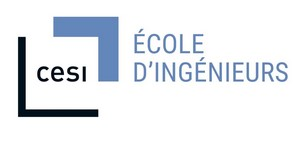

<h1 align='center'>Projet Leyenda - Livrable 2 - Traitement d'images</h1>
<h3 align='center'>Youssef AYARI, Matthieu DECLERCQ, Thomas PETAIN, Julien BARON, Jean-Baptiste CASTELLANI</h1>

## Sommaire

* [Introduction](#chapter1)
* [1. Contraintes](#chapter2)
* [2. Configuration de l'environnement](#chapter3)
    * [2.1 Import des librairies Python](#section_2_1)
    * [2.2 Utilisation du GPU](#section_2_2)
* [3. Préparation du dataset](#chapter4)
    * [3.1 Création d'un jeu d'entraînement et de test](#section_3_1)
    * [3.2 Bruitage du jeu de données](#section_3_2)
* [4. Création du Modèle](#chapter5)
    * [4.1 Encodeur Décodeur](#section_5_1)
    * [4.2 Implémentation du modèle](#section_5_2)
    * [4.3 Amélioration du modèle](#section_5_3)
* [5. Mesure de la performance](#chapter6)
* [6. Etude de cas](#chapiter7)
* [7. Conclusion](#chapiter8)

## Introduction <a class="anchor" id="chapter1"></a>

<div style="text-align: justify">Dans le cadre de ce projet, l'entreprise TouNum, spécialisée dans la numérisation de documents, souhaite étendre leur gamme de services pour inclure des outils de Machine Learning. En effet, leur clientèle possède une grande quantité de données à numériser au format papier. Dans le but de rester compétitif dans ce secteur d’activité, l’entreprise décide d’innover et de proposer un service de catégorisation qui serait plus que valorisable. Afin de mener à bien cette tâche, des spécialistes en Data Science du CESI ont été contactés.
<p><br>
    
<div style="text-align: justify">Dans la partie précedente nous avons classifié les photos et les autres images par le biais d'un CNN. Dans ce notebook nous abroderons le débruitage des photos afin de faciliter leur traitement par les algorithmes de machine Learning</div>

## 1. Contraintes <a class="anchor" id="chapter2"></a>

<div style="text-align: justify">Dans le but d'opérer une opération de débruitage nous devons réfléchir à une méthode qui nous permettra de réduire la dimension de notre image. En effet, lorsque nous traitons des images nous avons beaucoup de caractéristiques en entrée. Prenons une image 28 x 28 pixel, dans ce cas nous aurons 784 inputs dans notre réseau de neurones. Avec autant de dimension ce qui rend le traitement et l'analyse compliqué.</div><br>

<div style="text-align: justify">Nous connaissons des méthodes permettant de réduire les dimensions de notre image. Nous pouvons citer dans un premier temps l'ACP ( Analyse en Composantes Principale). Néanmoins cette solution ne nous satisfait pas car les relations entre les caractéristiques et les points de données dans un espace à haute dimension présentent une relation non linéaire.</div><br>

<div style="text-align: justify">Dans ce cas de figure nous pouvons alors nous tourner vers le TSNE. Néanmoins, cet algorithme bien que très efficace ne convainc pas du fait qu'il reste très gourmand en ressources. Par conséquent nous nous devons trouver un algorithme qui nous permet de garder une approche non linéaire tout en conservant des performances acceptables.</div><br>


## 2. Configuration de l'environnement <a class="anchor" id="chapter3"></a>

Tout comme dans le premier livrable nous nous devons de préparer notre environnement de travail pour mener à bien notre projet. Par conséquent nous reviendrons sur les mêmes points qui ont été aborder précédemment qui sont : l'import des librairies Python et l'utilisattion du GPU. 

### 2.1 Import des librairies Python <a class="anchor" id="section_3_1"></a>

Dans le cadre de ce premier livrable, nous avons décidé d’importer plusieurs librairies Python que nous allons présenter :
<ul>
    <li style="text-align: justify"><strong>TensorFlow</strong> : est un outil open source d'apprentissage automatique développé par Google. Il est l'un des outils les plus utilisés en IA dans le domaine de l'apprentissage machine. Celui-ci contient de nombreuses implémentations de blocs nécessaire à la construction de réseaux de neurones couramment utilisés tels que des couches, des fonctions d'activation, des optimiseurs et une multitude d'outils pour faciliter le travail avec des images ou des textes afin de simplifier le codage nécessaire à l'écriture de code de réseau de neurones profond. <strong>Keras</strong> est l’API haut niveau s’exécutant sur la plateforme d’apprentissage automatique Tensorflow. Elle permet de faciliter la création et l’entraînement des modèles de deep learning.</li><br>
</ul>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import numpy as np
import pathlib

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, Dropout
from tensorflow.keras.models import Model, Sequential
from random import randrange
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers

### 2.2 Utilisation du GPU <a class="anchor" id="section_2_1"></a>

<div style="text-align: justify">Dans l'optique d’avoir de meilleures performances tout au long de ce projet notamment durant l’entraînement du modèle, nous avons décidé de faire passer le traitement des données par le GPU. Pour ce faire, la ligne ci-dessous nous indique si le système détecte un GPU qui peut être utilisé. (Seules les cartes Nvdia avec Cuda installé sont reconnues par Tensorflow).<div>

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 3. Préparation du dataset <a class="anchor" id="chapter4"></a>

<div style="text-align: justify"> Nous avons vu comment dans le premier livrable comment préparer notre jeux de données pour les algorithme de deep learning. Néanmoins, nous devrons rajouter intentionellement du bruit sur nos images dans le but de pouvoir entrainer nos modèles dans les meilleures conditons.</div>

In [3]:
data_dir = pathlib.Path("Class")
image_h = 256
image_w = 256
batch_s = 9

### 3.1 Création des jeux d'entrainement et de test <a class="anchor" id="section_4_1"></a>

<div style="text-align: justify">Pour préparer le jeu de données, nous le séparons en deux sous-ensembles homogènes afin d'éviter la sous-représentation de classe. Le premier sous-ensemble dit d'entraînement permettra au modèle d'ajuster ses poids et par conséquent améliorer sa classification. Le second nous permet d'évaluer la classification du modèle. C'est sur ce jeu de données qu'on se base pour le calcul de la précision du modèle.<div>   

In [4]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="training",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  color_mode="rgb"
)

# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="validation",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  color_mode="rgb"
)

Found 10000 files belonging to 1 classes.
Using 8000 files for training.
Found 10000 files belonging to 1 classes.
Using 2000 files for validation.


### 3.2 Bruitage du jeu de données <a class="anchor" id="section_4_2"></a>

<div style="text-align: justify">Notre dataset ne contenant pas d'image bruitée, nous devons par conséquent ajouter un bruit gaussien aléatoire sur chaque image. Pour ce faire nous générons aléatoirement un entier que nous multiplions par un facteur et additionnons à notre image.</div>

In [5]:
#process image 
def preprocess(data):
    data = np.array(data, dtype=np.float32) #conversion de l'image en narray de nombre de flotan
    data = data.astype('float32') / 255.0 #Normalisation des données de narray
    data = np.reshape(data, (len(data), image_h, image_w, 3))# redimensionnement de l'array
    return data

#Bruitage de l'image
def noise_it(data, noise_factor = 0.2):
    data_noisy = data + noise_factor * tf.random.normal(shape = data.shape)
    return np.clip(data_noisy, 0., 1.)#Normalization des données après le bruitage
    
#Sépare les features des labels 
def split_dataset(data):
    for photo_batch, label_batch in data:
        photo = photo_batch
        break
    return photo

x_train = split_dataset(train_set)
x_test = split_dataset(test_set)

x_train = preprocess(x_train)
x_test = preprocess(x_test)

x_train_noisy = noise_it(x_train) 
x_test_noisy = noise_it(x_test)

Nous pouvons voir ci-dessous que les images issus de notre dataset on bien été bruité.

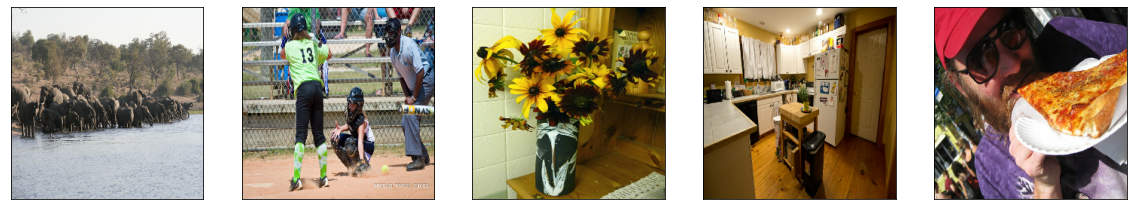

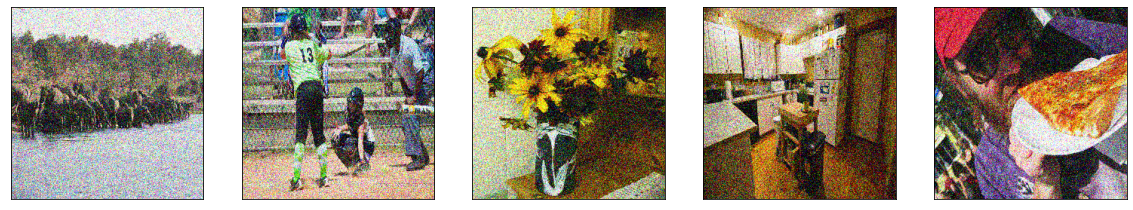

In [6]:
#Affichage d'image
def display_image(X, n):
    plt.figure(figsize=(20, 20))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(X[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

display_image(x_train,5)
display_image(x_train_noisy, 5)

## 4 Création du modèle <a class="anchor" id="chapter5"></a>

<div style="text-align: justify">Nous avons maintenaint un dataset nétoyé et prêt à être exploité pour l'entrainement des modèles. Par conséquent cette partie s'axe sur le dévloppement et l'évaluation du modèle.</div>

### 4.1 Encodeur Décodeur <a class="anchor" id = "section_5_1">

<div style="text-align: justify">Cette architecture fonctionne sur la base de 2 concepts qui nous permettrons de prendre en entré une image bruité :</div><br>

<div style="text-align: justify">-<strong>l'Encodeur</strong>: L'objectif de cette étape est de sous-échantillonner l’image en entrée. Pour ce faire nous allons utiliser des opérations de convolution comme vu précédemment dans le livrable 1. Ce qui aura pour conséquence de réduire la taille de l’image d’entrée. A la suite des opérations de convolution nous obtiendrons une représentation vectorielle de notre image appelée espace latent.</div><br>

<div style="text-align: justify">-<strong>Décodeur</strong>: La seconde partie appelée décodeur prend en entrée l’espace latent généré par l’encodeur. Son objectif sera de reconstruire l’image en supprimant le bruit . Pour ce faire, nous utilisons des couches de convolutions transposées. Ces couches, vont rééchantillonner l’image à partir des caractéristiques de l’espace latent. Comme le montre le schéma ci-dessous :</div><br>

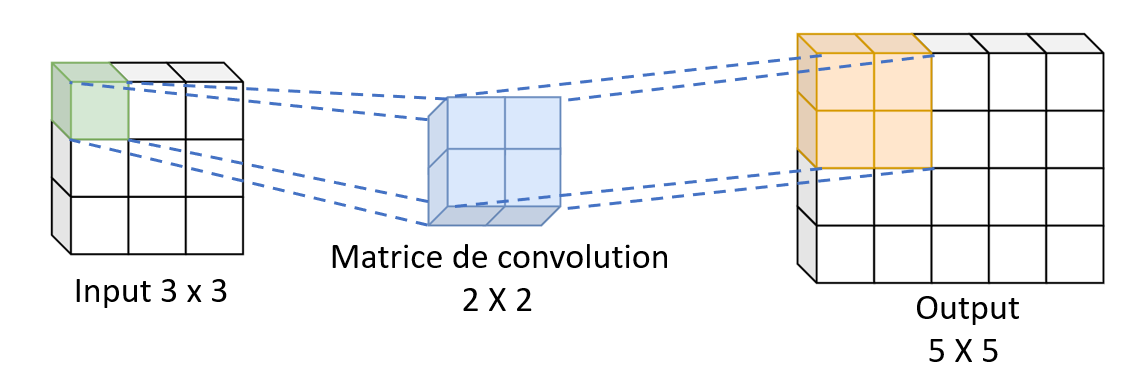
<br>

<div style="text-align: justify">Cette architecture répond parfaitement à la problématique posée précédemment dans le notebook. En effet, nous avons pu diminuer la dimension de manière non-linéaire tout en gardant des performances qui sont très acceptables.</div>


### 4.2 Implémentation du modèle <a class="anchor" id = "section_5_2">

<div style="text-align: justify">Dans cette partie nous allons implémenter le modèle d’auto-encodeur décrit précédemment. Nous définissons au préalable les variables utiles au modèle tel que le nombre d'époque ou la taille du batch.</div>

In [7]:
nb_epochs = 1000
batch_size = 18

#### 4.2.1 Définition du modèle <a class="anchor" id = "section_5_2_1">

In [8]:
inputs = Input(shape=(image_w, image_w, 3))

#Encoder
x = Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)


# Decoder
x = Conv2D(256, (3, 3),  activation="relu", padding="same")(x)
x = Conv2D(128, (3, 3),  activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(inputs, x)
model_opt = tf.keras.optimizers.Adam()
autoencoder.compile(optimizer=model_opt, loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       147584

#### 4.2.3 Sauvegarde du meilleure modèle  <a class="anchor" id="section_5_2_3"></a>

In [9]:
callback_bestmodel = tf.keras.callbacks.ModelCheckpoint(filepath='./models/new_model.h5', verbose=0, save_best_only=True)
callbacks_list = [callback_bestmodel]

#### 4.2.4 Entrainement du modèle  <a class="anchor" id="section_5_2_4"></a>

In [10]:
history = autoencoder.fit(
    x=x_train_noisy,
    y=x_train,
    epochs=nb_epochs,
    batch_size=batch_size,
    validation_data=(x_test_noisy, x_test),
    callbacks = callbacks_list
)

Epoch 1/1000
1/1 [==============================] - 8s 8s/step - loss: 0.6930 - val_loss: 0.6954
Epoch 2/1000
1/1 [==============================] - 0s 181ms/step - loss: 0.6890 - val_loss: 0.7240
Epoch 3/1000
1/1 [==============================] - 0s 183ms/step - loss: 0.7150 - val_loss: 0.6914
Epoch 4/1000
1/1 [==============================] - 0s 180ms/step - loss: 0.6918 - val_loss: 0.6905
Epoch 5/1000
1/1 [==============================] - 0s 181ms/step - loss: 0.6910 - val_loss: 0.6911
Epoch 6/1000
1/1 [==============================] - 0s 183ms/step - loss: 0.6889 - val_loss: 0.7021
Epoch 7/1000
1/1 [==============================] - 0s 184ms/step - loss: 0.6922 - val_loss: 0.6947
Epoch 8/1000
1/1 [==============================] - 0s 183ms/step - loss: 0.6893 - val_loss: 0.6918
Epoch 9/1000
1/1 [==============================] - 0s 182ms/step - loss: 0.6894 - val_loss: 0.6896
Epoch 10/1000
1/1 [==============================] - 0s 179ms/step - loss: 0.6883 - val_loss: 0.6874
Ep

1/1 [==============================] - 0s 183ms/step - loss: 0.5191 - val_loss: 0.4972
Epoch 163/1000
1/1 [==============================] - 0s 185ms/step - loss: 0.5189 - val_loss: 0.4971
Epoch 164/1000
1/1 [==============================] - 0s 183ms/step - loss: 0.5189 - val_loss: 0.4964
Epoch 165/1000
1/1 [==============================] - 0s 180ms/step - loss: 0.5186 - val_loss: 0.4960
Epoch 166/1000
1/1 [==============================] - 0s 181ms/step - loss: 0.5183 - val_loss: 0.4956
Epoch 167/1000
1/1 [==============================] - 0s 181ms/step - loss: 0.5180 - val_loss: 0.4953
Epoch 168/1000
1/1 [==============================] - 0s 180ms/step - loss: 0.5180 - val_loss: 0.4953
Epoch 169/1000
1/1 [==============================] - 0s 181ms/step - loss: 0.5176 - val_loss: 0.4952
Epoch 170/1000
1/1 [==============================] - 0s 178ms/step - loss: 0.5174 - val_loss: 0.4949
Epoch 171/1000
1/1 [==============================] - 0s 179ms/step - loss: 0.5172 - val_loss: 0.

1/1 [==============================] - 0s 187ms/step - loss: 0.5067 - val_loss: 0.4875
Epoch 323/1000
1/1 [==============================] - 0s 187ms/step - loss: 0.5064 - val_loss: 0.4872
Epoch 324/1000
1/1 [==============================] - 0s 192ms/step - loss: 0.5062 - val_loss: 0.4867
Epoch 325/1000
1/1 [==============================] - 0s 190ms/step - loss: 0.5061 - val_loss: 0.4869
Epoch 326/1000
1/1 [==============================] - 0s 186ms/step - loss: 0.5062 - val_loss: 0.4871
Epoch 327/1000
1/1 [==============================] - 0s 184ms/step - loss: 0.5061 - val_loss: 0.4871
Epoch 328/1000
1/1 [==============================] - 0s 186ms/step - loss: 0.5058 - val_loss: 0.4867
Epoch 329/1000
1/1 [==============================] - 0s 186ms/step - loss: 0.5056 - val_loss: 0.4867
Epoch 330/1000
1/1 [==============================] - 0s 182ms/step - loss: 0.5059 - val_loss: 0.4867
Epoch 331/1000
1/1 [==============================] - 0s 186ms/step - loss: 0.5056 - val_loss: 0.

1/1 [==============================] - 0s 190ms/step - loss: 0.5020 - val_loss: 0.4890
Epoch 483/1000
1/1 [==============================] - 0s 189ms/step - loss: 0.5012 - val_loss: 0.4871
Epoch 484/1000
1/1 [==============================] - 0s 205ms/step - loss: 0.4999 - val_loss: 0.4872
Epoch 485/1000
1/1 [==============================] - 0s 249ms/step - loss: 0.4996 - val_loss: 0.4880
Epoch 486/1000
1/1 [==============================] - 0s 208ms/step - loss: 0.5003 - val_loss: 0.4881
Epoch 487/1000
1/1 [==============================] - 0s 188ms/step - loss: 0.5009 - val_loss: 0.4885
Epoch 488/1000
1/1 [==============================] - 0s 192ms/step - loss: 0.5005 - val_loss: 0.4875
Epoch 489/1000
1/1 [==============================] - 0s 187ms/step - loss: 0.4999 - val_loss: 0.4873
Epoch 490/1000
1/1 [==============================] - 0s 188ms/step - loss: 0.4995 - val_loss: 0.4877
Epoch 491/1000
1/1 [==============================] - 0s 187ms/step - loss: 0.4998 - val_loss: 0.

1/1 [==============================] - 0s 186ms/step - loss: 0.4965 - val_loss: 0.4902
Epoch 643/1000
1/1 [==============================] - 0s 188ms/step - loss: 0.4963 - val_loss: 0.4900
Epoch 644/1000
1/1 [==============================] - 0s 186ms/step - loss: 0.4964 - val_loss: 0.4890
Epoch 645/1000
1/1 [==============================] - 0s 187ms/step - loss: 0.4963 - val_loss: 0.4896
Epoch 646/1000
1/1 [==============================] - 0s 186ms/step - loss: 0.4964 - val_loss: 0.4899
Epoch 647/1000
1/1 [==============================] - 0s 194ms/step - loss: 0.4962 - val_loss: 0.4903
Epoch 648/1000
1/1 [==============================] - 0s 186ms/step - loss: 0.4964 - val_loss: 0.4894
Epoch 649/1000
1/1 [==============================] - 0s 191ms/step - loss: 0.4965 - val_loss: 0.4905
Epoch 650/1000
1/1 [==============================] - 0s 186ms/step - loss: 0.4968 - val_loss: 0.4902
Epoch 651/1000
1/1 [==============================] - 0s 186ms/step - loss: 0.4968 - val_loss: 0.

1/1 [==============================] - 0s 226ms/step - loss: 0.4941 - val_loss: 0.4921
Epoch 803/1000
1/1 [==============================] - 0s 215ms/step - loss: 0.4941 - val_loss: 0.4932
Epoch 804/1000
1/1 [==============================] - 0s 220ms/step - loss: 0.4942 - val_loss: 0.4920
Epoch 805/1000
1/1 [==============================] - 0s 235ms/step - loss: 0.4942 - val_loss: 0.4927
Epoch 806/1000
1/1 [==============================] - 0s 224ms/step - loss: 0.4940 - val_loss: 0.4928
Epoch 807/1000
1/1 [==============================] - 0s 211ms/step - loss: 0.4941 - val_loss: 0.4923
Epoch 808/1000
1/1 [==============================] - 0s 207ms/step - loss: 0.4940 - val_loss: 0.4925
Epoch 809/1000
1/1 [==============================] - 0s 217ms/step - loss: 0.4940 - val_loss: 0.4929
Epoch 810/1000
1/1 [==============================] - 0s 186ms/step - loss: 0.4942 - val_loss: 0.4927
Epoch 811/1000
1/1 [==============================] - 0s 188ms/step - loss: 0.4942 - val_loss: 0.

1/1 [==============================] - 0s 190ms/step - loss: 0.4931 - val_loss: 0.4958
Epoch 963/1000
1/1 [==============================] - 0s 189ms/step - loss: 0.4933 - val_loss: 0.4948
Epoch 964/1000
1/1 [==============================] - 0s 194ms/step - loss: 0.4937 - val_loss: 0.4962
Epoch 965/1000
1/1 [==============================] - 0s 190ms/step - loss: 0.4938 - val_loss: 0.4952
Epoch 966/1000
1/1 [==============================] - 0s 193ms/step - loss: 0.4936 - val_loss: 0.4959
Epoch 967/1000
1/1 [==============================] - 0s 195ms/step - loss: 0.4931 - val_loss: 0.4946
Epoch 968/1000
1/1 [==============================] - 0s 188ms/step - loss: 0.4928 - val_loss: 0.4950
Epoch 969/1000
1/1 [==============================] - 0s 194ms/step - loss: 0.4927 - val_loss: 0.4951
Epoch 970/1000
1/1 [==============================] - 0s 191ms/step - loss: 0.4929 - val_loss: 0.4951
Epoch 971/1000
1/1 [==============================] - 0s 191ms/step - loss: 0.4930 - val_loss: 0.

#### 4.2.5 Visualisation des résultats <a class="anchor" id="section_5_2_4"></a>

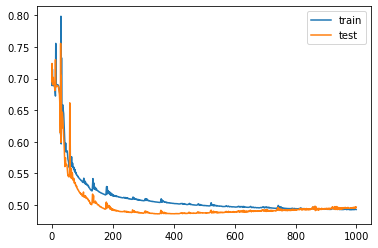

In [11]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

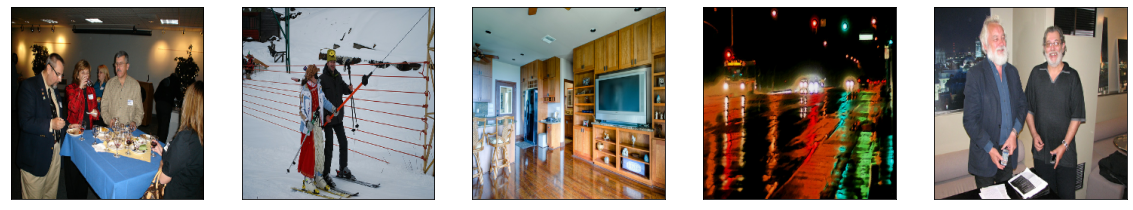

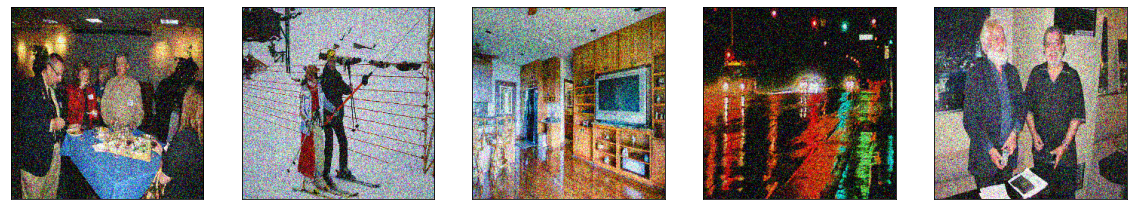

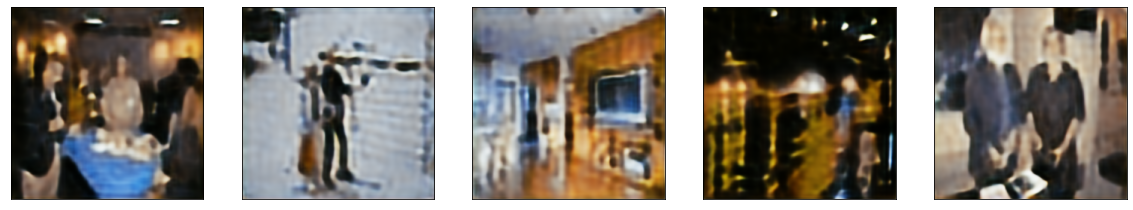

In [12]:
model_dir = pathlib.Path("models//best_model.h5")
model = keras.models.load_model(model_dir)
predictions = model.predict(x_test_noisy)
display_image(x_test, 5)
display_image(x_test_noisy, 5)
display_image(predictions, 5)

### 4.3 Amélioration du modèle <a class="anchor" id="section_5_3"></a>

#### 4.3.1 Définition des layers <a class="anchor" id="section_5_3_1"></a>

In [13]:
from keras.initializers import orthogonal
import keras.models as models
import keras.layers as layers
def Conv2DLayer(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = Conv2D(filters, kernel_size=kernel, strides=strides, padding=padding,
                      kernel_initializer=kernel_init, name=prefix+'conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

def Transpose_Conv2D(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = Conv2DTranspose(filters, kernel_size=kernel, strides=strides, padding=padding,
                               kernel_initializer=kernel_init, name=prefix+'de-conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

#### 4.3.2 Définition du modèle  <a class="anchor" id="section_5_3_2"></a>

In [14]:
def AutoEncdoer(input_shape):
    inputs = Input(shape=input_shape)
    
    # 256 x 256
    conv1 = Conv2DLayer(inputs, 64, 3, strides=1, padding='same', block_id=1)
    conv2 = Conv2DLayer(conv1, 64, 3, strides=2, padding='same', block_id=2)
    
    # 128 x 128
    conv3 = Conv2DLayer(conv2, 128, 5, strides=2, padding='same', block_id=3)
    
    # 64 x 64
    conv4 = Conv2DLayer(conv3, 128, 3, strides=1, padding='same', block_id=4)
    conv5 = Conv2DLayer(conv4, 256, 5, strides=2, padding='same', block_id=5)
    
    # 32 x 32
    conv6 = Conv2DLayer(conv5, 512, 3, strides=2, padding='same', block_id=6)
    
    # 16 x 16
    deconv1 = Transpose_Conv2D(conv6, 512, 3, strides=2, padding='same', block_id=7)
    
    # 32 x 32
    skip1 = layers.concatenate([deconv1, conv5], name='skip1')
    conv7 = Conv2DLayer(skip1, 256, 3, strides=1, padding='same', block_id=8)
    deconv2 = Transpose_Conv2D(conv7, 128, 3, strides=2, padding='same', block_id=9)
    
    # 64 x 64
    skip2 = layers.concatenate([deconv2, conv3], name='skip2')
    conv8 = Conv2DLayer(skip2, 128, 5, strides=1, padding='same', block_id=10)
    deconv3 = Transpose_Conv2D(conv8, 64, 3, strides=2, padding='same', block_id=11)
    
    # 128 x 128
    skip3 = layers.concatenate([deconv3, conv2], name='skip3')
    conv9 = Conv2DLayer(skip3, 64, 5, strides=1, padding='same', block_id=12)
    deconv4 = Transpose_Conv2D(conv9, 64, 3, strides=2, padding='same', block_id=13)
    
    # 256 x 256
    skip3 = layers.concatenate([deconv4, conv1])
    conv10 = layers.Conv2D(3, 3, strides=1, padding='same', activation='sigmoid',
                       kernel_initializer=orthogonal(), name='final_conv')(skip3)

    
    return models.Model(inputs=inputs, outputs=conv10)

In [15]:
model = AutoEncdoer((image_h, image_w, 3))
model_opt = tf.keras.optimizers.Adam(lr=0.002)
model.compile(optimizer=model_opt, loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\jbcst\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


#### 4.3.3 Sauvegarde du meilleure modèle  <a class="anchor" id="section_5_3_3"></a>

In [16]:
callback_bestmodel_improved = tf.keras.callbacks.ModelCheckpoint(filepath=pathlib.Path("models_improved//new_model.h5"), verbose=0, save_best_only=True)
callbacks_list_improved = [callback_bestmodel_improved]

#### 4.3.3 Entrainement du modèle <a class="anchor" id="section_5_3_3"></a>

In [17]:
history = model.fit(
    x=x_train_noisy,
    y=x_train,
    epochs=nb_epochs,
    batch_size=18,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks = callbacks_list_improved
)

Epoch 1/1000
1/1 [==============================] - 5s 5s/step - loss: 0.9785 - accuracy: 0.2895 - val_loss: 0.6945 - val_accuracy: 0.3218
Epoch 2/1000
1/1 [==============================] - 0s 397ms/step - loss: 0.6561 - accuracy: 0.3469 - val_loss: 1.0623 - val_accuracy: 0.4120
Epoch 3/1000
1/1 [==============================] - 0s 462ms/step - loss: 0.5813 - accuracy: 0.3715 - val_loss: 1.9785 - val_accuracy: 0.3771
Epoch 4/1000
1/1 [==============================] - 0s 409ms/step - loss: 0.5914 - accuracy: 0.4410 - val_loss: 4.6107 - val_accuracy: 0.4621
Epoch 5/1000
1/1 [==============================] - 0s 469ms/step - loss: 0.5847 - accuracy: 0.4148 - val_loss: 5.3425 - val_accuracy: 0.4973
Epoch 6/1000
1/1 [==============================] - 0s 455ms/step - loss: 0.5639 - accuracy: 0.4492 - val_loss: 6.3419 - val_accuracy: 0.4214
Epoch 7/1000
1/1 [==============================] - 0s 435ms/step - loss: 0.5473 - accuracy: 0.4928 - val_loss: 6.9039 - val_accuracy: 0.3659
Epoch 8/1

1/1 [==============================] - 0s 414ms/step - loss: 0.5017 - accuracy: 0.6555 - val_loss: 0.6026 - val_accuracy: 0.5232
Epoch 116/1000
1/1 [==============================] - 0s 388ms/step - loss: 0.5016 - accuracy: 0.6545 - val_loss: 0.6034 - val_accuracy: 0.5278
Epoch 117/1000
1/1 [==============================] - 0s 388ms/step - loss: 0.5016 - accuracy: 0.6516 - val_loss: 0.6036 - val_accuracy: 0.5226
Epoch 118/1000
1/1 [==============================] - 0s 387ms/step - loss: 0.5015 - accuracy: 0.6558 - val_loss: 0.6032 - val_accuracy: 0.5159
Epoch 119/1000
1/1 [==============================] - 0s 387ms/step - loss: 0.5014 - accuracy: 0.6599 - val_loss: 0.6028 - val_accuracy: 0.5151
Epoch 120/1000
1/1 [==============================] - 0s 388ms/step - loss: 0.5014 - accuracy: 0.6603 - val_loss: 0.6025 - val_accuracy: 0.5194
Epoch 121/1000
1/1 [==============================] - 0s 387ms/step - loss: 0.5013 - accuracy: 0.6573 - val_loss: 0.6019 - val_accuracy: 0.5216
Epoch 1

Epoch 172/1000
1/1 [==============================] - 0s 385ms/step - loss: 0.4986 - accuracy: 0.6953 - val_loss: 0.5908 - val_accuracy: 0.5135
Epoch 173/1000
1/1 [==============================] - 0s 385ms/step - loss: 0.4986 - accuracy: 0.7004 - val_loss: 0.5905 - val_accuracy: 0.5136
Epoch 174/1000
1/1 [==============================] - 0s 386ms/step - loss: 0.4987 - accuracy: 0.7012 - val_loss: 0.5907 - val_accuracy: 0.5143
Epoch 175/1000
1/1 [==============================] - 0s 388ms/step - loss: 0.4986 - accuracy: 0.6987 - val_loss: 0.5904 - val_accuracy: 0.5150
Epoch 176/1000
1/1 [==============================] - 0s 386ms/step - loss: 0.4985 - accuracy: 0.6987 - val_loss: 0.5902 - val_accuracy: 0.5153
Epoch 177/1000
1/1 [==============================] - 0s 392ms/step - loss: 0.4985 - accuracy: 0.7010 - val_loss: 0.5902 - val_accuracy: 0.5152
Epoch 178/1000
1/1 [==============================] - 0s 472ms/step - loss: 0.4984 - accuracy: 0.6999 - val_loss: 0.5901 - val_accuracy:

Epoch 229/1000
1/1 [==============================] - 0s 414ms/step - loss: 0.4970 - accuracy: 0.7284 - val_loss: 0.5731 - val_accuracy: 0.5251
Epoch 230/1000
1/1 [==============================] - 0s 387ms/step - loss: 0.4970 - accuracy: 0.7278 - val_loss: 0.5726 - val_accuracy: 0.5232
Epoch 231/1000
1/1 [==============================] - 0s 389ms/step - loss: 0.4969 - accuracy: 0.7280 - val_loss: 0.5723 - val_accuracy: 0.5227
Epoch 232/1000
1/1 [==============================] - 0s 392ms/step - loss: 0.4969 - accuracy: 0.7279 - val_loss: 0.5719 - val_accuracy: 0.5234
Epoch 233/1000
1/1 [==============================] - 0s 386ms/step - loss: 0.4969 - accuracy: 0.7270 - val_loss: 0.5714 - val_accuracy: 0.5247
Epoch 234/1000
1/1 [==============================] - 0s 387ms/step - loss: 0.4969 - accuracy: 0.7276 - val_loss: 0.5712 - val_accuracy: 0.5254
Epoch 235/1000
1/1 [==============================] - 0s 387ms/step - loss: 0.4968 - accuracy: 0.7263 - val_loss: 0.5712 - val_accuracy:

Epoch 286/1000
1/1 [==============================] - 0s 388ms/step - loss: 0.4960 - accuracy: 0.7504 - val_loss: 0.5536 - val_accuracy: 0.5443
Epoch 287/1000
1/1 [==============================] - 0s 390ms/step - loss: 0.4959 - accuracy: 0.7432 - val_loss: 0.5536 - val_accuracy: 0.5452
Epoch 288/1000
1/1 [==============================] - 0s 390ms/step - loss: 0.4959 - accuracy: 0.7451 - val_loss: 0.5527 - val_accuracy: 0.5455
Epoch 289/1000
1/1 [==============================] - 0s 389ms/step - loss: 0.4959 - accuracy: 0.7496 - val_loss: 0.5531 - val_accuracy: 0.5453
Epoch 290/1000
1/1 [==============================] - 0s 389ms/step - loss: 0.4959 - accuracy: 0.7490 - val_loss: 0.5533 - val_accuracy: 0.5453
Epoch 291/1000
1/1 [==============================] - 0s 390ms/step - loss: 0.4959 - accuracy: 0.7465 - val_loss: 0.5522 - val_accuracy: 0.5459
Epoch 292/1000
1/1 [==============================] - 0s 437ms/step - loss: 0.4959 - accuracy: 0.7504 - val_loss: 0.5516 - val_accuracy:

Epoch 343/1000
1/1 [==============================] - 0s 431ms/step - loss: 0.4952 - accuracy: 0.7594 - val_loss: 0.5334 - val_accuracy: 0.5929
Epoch 344/1000
1/1 [==============================] - 0s 388ms/step - loss: 0.4952 - accuracy: 0.7601 - val_loss: 0.5350 - val_accuracy: 0.5916
Epoch 345/1000
1/1 [==============================] - 0s 388ms/step - loss: 0.4953 - accuracy: 0.7563 - val_loss: 0.5345 - val_accuracy: 0.5921
Epoch 346/1000
1/1 [==============================] - 0s 388ms/step - loss: 0.4952 - accuracy: 0.7618 - val_loss: 0.5323 - val_accuracy: 0.5967
Epoch 347/1000
1/1 [==============================] - 0s 387ms/step - loss: 0.4952 - accuracy: 0.7656 - val_loss: 0.5325 - val_accuracy: 0.6074
Epoch 348/1000
1/1 [==============================] - 0s 392ms/step - loss: 0.4952 - accuracy: 0.7656 - val_loss: 0.5337 - val_accuracy: 0.6016
Epoch 349/1000
1/1 [==============================] - 0s 387ms/step - loss: 0.4952 - accuracy: 0.7617 - val_loss: 0.5320 - val_accuracy:

Epoch 400/1000
1/1 [==============================] - 0s 388ms/step - loss: 0.4947 - accuracy: 0.7687 - val_loss: 0.5149 - val_accuracy: 0.6283
Epoch 401/1000
1/1 [==============================] - 0s 385ms/step - loss: 0.4947 - accuracy: 0.7697 - val_loss: 0.5157 - val_accuracy: 0.6362
Epoch 402/1000
1/1 [==============================] - 0s 387ms/step - loss: 0.4946 - accuracy: 0.7730 - val_loss: 0.5151 - val_accuracy: 0.6418
Epoch 403/1000
1/1 [==============================] - 0s 392ms/step - loss: 0.4947 - accuracy: 0.7779 - val_loss: 0.5159 - val_accuracy: 0.6254
Epoch 404/1000
1/1 [==============================] - 0s 387ms/step - loss: 0.4947 - accuracy: 0.7694 - val_loss: 0.5136 - val_accuracy: 0.6160
Epoch 405/1000
1/1 [==============================] - 0s 421ms/step - loss: 0.4947 - accuracy: 0.7676 - val_loss: 0.5145 - val_accuracy: 0.6258
Epoch 406/1000
1/1 [==============================] - 0s 394ms/step - loss: 0.4947 - accuracy: 0.7640 - val_loss: 0.5132 - val_accuracy:

Epoch 457/1000
1/1 [==============================] - 0s 387ms/step - loss: 0.4942 - accuracy: 0.7734 - val_loss: 0.4971 - val_accuracy: 0.6693
Epoch 458/1000
1/1 [==============================] - 0s 388ms/step - loss: 0.4943 - accuracy: 0.7750 - val_loss: 0.5011 - val_accuracy: 0.6831
Epoch 459/1000
1/1 [==============================] - 0s 388ms/step - loss: 0.4942 - accuracy: 0.7806 - val_loss: 0.5007 - val_accuracy: 0.6934
Epoch 460/1000
1/1 [==============================] - 0s 388ms/step - loss: 0.4942 - accuracy: 0.7811 - val_loss: 0.4972 - val_accuracy: 0.6868
Epoch 461/1000
1/1 [==============================] - 0s 412ms/step - loss: 0.4942 - accuracy: 0.7828 - val_loss: 0.4964 - val_accuracy: 0.6789
Epoch 462/1000
1/1 [==============================] - 0s 387ms/step - loss: 0.4942 - accuracy: 0.7794 - val_loss: 0.4991 - val_accuracy: 0.6765
Epoch 463/1000
1/1 [==============================] - 0s 389ms/step - loss: 0.4941 - accuracy: 0.7786 - val_loss: 0.4983 - val_accuracy:

Epoch 514/1000
1/1 [==============================] - 0s 397ms/step - loss: 0.4937 - accuracy: 0.7837 - val_loss: 0.4872 - val_accuracy: 0.7106
Epoch 515/1000
1/1 [==============================] - 0s 416ms/step - loss: 0.4937 - accuracy: 0.7827 - val_loss: 0.4860 - val_accuracy: 0.7120
Epoch 516/1000
1/1 [==============================] - 0s 464ms/step - loss: 0.4937 - accuracy: 0.7863 - val_loss: 0.4876 - val_accuracy: 0.7114
Epoch 517/1000
1/1 [==============================] - 0s 478ms/step - loss: 0.4937 - accuracy: 0.7897 - val_loss: 0.4881 - val_accuracy: 0.7143
Epoch 518/1000
1/1 [==============================] - 0s 416ms/step - loss: 0.4937 - accuracy: 0.7873 - val_loss: 0.4857 - val_accuracy: 0.7174
Epoch 519/1000
1/1 [==============================] - 0s 389ms/step - loss: 0.4937 - accuracy: 0.7877 - val_loss: 0.4866 - val_accuracy: 0.7122
Epoch 520/1000
1/1 [==============================] - 0s 393ms/step - loss: 0.4937 - accuracy: 0.7827 - val_loss: 0.4878 - val_accuracy:

Epoch 571/1000
1/1 [==============================] - 0s 390ms/step - loss: 0.4933 - accuracy: 0.7893 - val_loss: 0.4816 - val_accuracy: 0.7382
Epoch 572/1000
1/1 [==============================] - 0s 389ms/step - loss: 0.4933 - accuracy: 0.7851 - val_loss: 0.4809 - val_accuracy: 0.7273
Epoch 573/1000
1/1 [==============================] - 0s 435ms/step - loss: 0.4932 - accuracy: 0.7930 - val_loss: 0.4792 - val_accuracy: 0.7251
Epoch 574/1000
1/1 [==============================] - 0s 413ms/step - loss: 0.4933 - accuracy: 0.7938 - val_loss: 0.4800 - val_accuracy: 0.7348
Epoch 575/1000
1/1 [==============================] - 0s 447ms/step - loss: 0.4932 - accuracy: 0.7964 - val_loss: 0.4810 - val_accuracy: 0.7342
Epoch 576/1000
1/1 [==============================] - 0s 399ms/step - loss: 0.4932 - accuracy: 0.7925 - val_loss: 0.4795 - val_accuracy: 0.7428
Epoch 577/1000
1/1 [==============================] - 0s 403ms/step - loss: 0.4932 - accuracy: 0.7935 - val_loss: 0.4795 - val_accuracy:

Epoch 628/1000
1/1 [==============================] - 0s 389ms/step - loss: 0.4928 - accuracy: 0.7999 - val_loss: 0.4772 - val_accuracy: 0.7396
Epoch 629/1000
1/1 [==============================] - 0s 395ms/step - loss: 0.4929 - accuracy: 0.7932 - val_loss: 0.4766 - val_accuracy: 0.7423
Epoch 630/1000
1/1 [==============================] - 0s 394ms/step - loss: 0.4928 - accuracy: 0.7960 - val_loss: 0.4760 - val_accuracy: 0.7439
Epoch 631/1000
1/1 [==============================] - 0s 389ms/step - loss: 0.4929 - accuracy: 0.7997 - val_loss: 0.4765 - val_accuracy: 0.7510
Epoch 632/1000
1/1 [==============================] - 0s 389ms/step - loss: 0.4928 - accuracy: 0.7956 - val_loss: 0.4759 - val_accuracy: 0.7413
Epoch 633/1000
1/1 [==============================] - 0s 390ms/step - loss: 0.4928 - accuracy: 0.7995 - val_loss: 0.4759 - val_accuracy: 0.7365
Epoch 634/1000
1/1 [==============================] - 0s 387ms/step - loss: 0.4928 - accuracy: 0.8030 - val_loss: 0.4767 - val_accuracy:

Epoch 685/1000
1/1 [==============================] - 0s 386ms/step - loss: 0.4925 - accuracy: 0.7982 - val_loss: 0.4743 - val_accuracy: 0.7521
Epoch 686/1000
1/1 [==============================] - 0s 388ms/step - loss: 0.4924 - accuracy: 0.7948 - val_loss: 0.4747 - val_accuracy: 0.7491
Epoch 687/1000
1/1 [==============================] - 0s 387ms/step - loss: 0.4925 - accuracy: 0.8021 - val_loss: 0.4737 - val_accuracy: 0.7407
Epoch 688/1000
1/1 [==============================] - 0s 387ms/step - loss: 0.4924 - accuracy: 0.8049 - val_loss: 0.4740 - val_accuracy: 0.7464
Epoch 689/1000
1/1 [==============================] - 0s 389ms/step - loss: 0.4924 - accuracy: 0.8053 - val_loss: 0.4736 - val_accuracy: 0.7519
Epoch 690/1000
1/1 [==============================] - 0s 388ms/step - loss: 0.4925 - accuracy: 0.8013 - val_loss: 0.4741 - val_accuracy: 0.7405
Epoch 691/1000
1/1 [==============================] - 0s 390ms/step - loss: 0.4924 - accuracy: 0.8017 - val_loss: 0.4747 - val_accuracy:

Epoch 742/1000
1/1 [==============================] - 0s 418ms/step - loss: 0.4920 - accuracy: 0.8042 - val_loss: 0.4722 - val_accuracy: 0.7494
Epoch 743/1000
1/1 [==============================] - 0s 409ms/step - loss: 0.4921 - accuracy: 0.8085 - val_loss: 0.4741 - val_accuracy: 0.7541
Epoch 744/1000
1/1 [==============================] - 0s 410ms/step - loss: 0.4921 - accuracy: 0.8100 - val_loss: 0.4722 - val_accuracy: 0.7592
Epoch 745/1000
1/1 [==============================] - 0s 412ms/step - loss: 0.4920 - accuracy: 0.8066 - val_loss: 0.4720 - val_accuracy: 0.7526
Epoch 746/1000
1/1 [==============================] - 0s 408ms/step - loss: 0.4920 - accuracy: 0.8066 - val_loss: 0.4734 - val_accuracy: 0.7446
Epoch 747/1000
1/1 [==============================] - 0s 407ms/step - loss: 0.4920 - accuracy: 0.8077 - val_loss: 0.4728 - val_accuracy: 0.7504
Epoch 748/1000
1/1 [==============================] - 0s 414ms/step - loss: 0.4920 - accuracy: 0.8027 - val_loss: 0.4720 - val_accuracy:

Epoch 799/1000
1/1 [==============================] - 0s 388ms/step - loss: 0.4916 - accuracy: 0.8069 - val_loss: 0.4715 - val_accuracy: 0.7609
Epoch 800/1000
1/1 [==============================] - 0s 393ms/step - loss: 0.4916 - accuracy: 0.8113 - val_loss: 0.4726 - val_accuracy: 0.7560
Epoch 801/1000
1/1 [==============================] - 0s 426ms/step - loss: 0.4916 - accuracy: 0.8136 - val_loss: 0.4716 - val_accuracy: 0.7607
Epoch 802/1000
1/1 [==============================] - 0s 387ms/step - loss: 0.4915 - accuracy: 0.8122 - val_loss: 0.4715 - val_accuracy: 0.7572
Epoch 803/1000
1/1 [==============================] - 0s 440ms/step - loss: 0.4915 - accuracy: 0.8104 - val_loss: 0.4726 - val_accuracy: 0.7515
Epoch 804/1000
1/1 [==============================] - 0s 391ms/step - loss: 0.4915 - accuracy: 0.8083 - val_loss: 0.4722 - val_accuracy: 0.7570
Epoch 805/1000
1/1 [==============================] - 0s 390ms/step - loss: 0.4915 - accuracy: 0.8114 - val_loss: 0.4716 - val_accuracy:

Epoch 856/1000
1/1 [==============================] - 0s 395ms/step - loss: 0.4911 - accuracy: 0.8120 - val_loss: 0.4723 - val_accuracy: 0.7611
Epoch 857/1000
1/1 [==============================] - 0s 393ms/step - loss: 0.4911 - accuracy: 0.8151 - val_loss: 0.4717 - val_accuracy: 0.7593
Epoch 858/1000
1/1 [==============================] - 0s 393ms/step - loss: 0.4911 - accuracy: 0.8146 - val_loss: 0.4714 - val_accuracy: 0.7598
Epoch 859/1000
1/1 [==============================] - 0s 391ms/step - loss: 0.4911 - accuracy: 0.8181 - val_loss: 0.4721 - val_accuracy: 0.7567
Epoch 860/1000
1/1 [==============================] - 0s 389ms/step - loss: 0.4911 - accuracy: 0.8131 - val_loss: 0.4719 - val_accuracy: 0.7544
Epoch 861/1000
1/1 [==============================] - 0s 392ms/step - loss: 0.4911 - accuracy: 0.8118 - val_loss: 0.4709 - val_accuracy: 0.7588
Epoch 862/1000
1/1 [==============================] - 0s 392ms/step - loss: 0.4911 - accuracy: 0.8136 - val_loss: 0.4714 - val_accuracy:

Epoch 913/1000
1/1 [==============================] - 0s 392ms/step - loss: 0.4907 - accuracy: 0.8196 - val_loss: 0.4715 - val_accuracy: 0.7531
Epoch 914/1000
1/1 [==============================] - 0s 386ms/step - loss: 0.4907 - accuracy: 0.8221 - val_loss: 0.4713 - val_accuracy: 0.7575
Epoch 915/1000
1/1 [==============================] - 0s 389ms/step - loss: 0.4907 - accuracy: 0.8210 - val_loss: 0.4711 - val_accuracy: 0.7646
Epoch 916/1000
1/1 [==============================] - 0s 396ms/step - loss: 0.4907 - accuracy: 0.8122 - val_loss: 0.4717 - val_accuracy: 0.7623
Epoch 917/1000
1/1 [==============================] - 0s 389ms/step - loss: 0.4907 - accuracy: 0.8131 - val_loss: 0.4713 - val_accuracy: 0.7581
Epoch 918/1000
1/1 [==============================] - 0s 394ms/step - loss: 0.4907 - accuracy: 0.8135 - val_loss: 0.4705 - val_accuracy: 0.7597
Epoch 919/1000
1/1 [==============================] - 0s 389ms/step - loss: 0.4907 - accuracy: 0.8174 - val_loss: 0.4720 - val_accuracy:

Epoch 970/1000
1/1 [==============================] - 0s 400ms/step - loss: 0.4903 - accuracy: 0.8229 - val_loss: 0.4708 - val_accuracy: 0.7636
Epoch 971/1000
1/1 [==============================] - 0s 387ms/step - loss: 0.4902 - accuracy: 0.8215 - val_loss: 0.4709 - val_accuracy: 0.7657
Epoch 972/1000
1/1 [==============================] - 0s 387ms/step - loss: 0.4903 - accuracy: 0.8205 - val_loss: 0.4719 - val_accuracy: 0.7587
Epoch 973/1000
1/1 [==============================] - 0s 416ms/step - loss: 0.4903 - accuracy: 0.8222 - val_loss: 0.4712 - val_accuracy: 0.7596
Epoch 974/1000
1/1 [==============================] - 0s 407ms/step - loss: 0.4902 - accuracy: 0.8234 - val_loss: 0.4710 - val_accuracy: 0.7585
Epoch 975/1000
1/1 [==============================] - 0s 387ms/step - loss: 0.4902 - accuracy: 0.8234 - val_loss: 0.4711 - val_accuracy: 0.7630
Epoch 976/1000
1/1 [==============================] - 0s 387ms/step - loss: 0.4902 - accuracy: 0.8216 - val_loss: 0.4711 - val_accuracy:

#### 4.3.4 Visualisation des résultats <a class="anchor" id="section_5_3_4"></a>

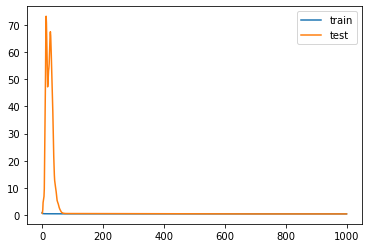

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

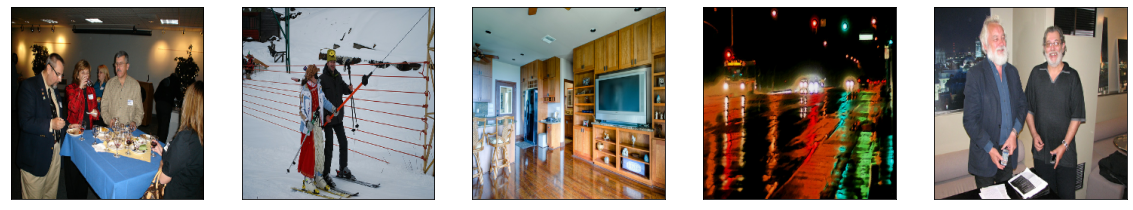

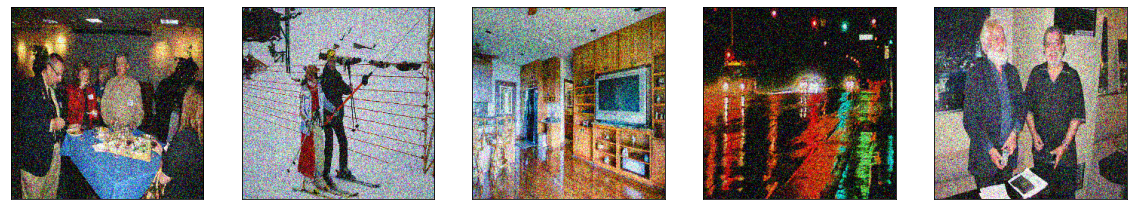

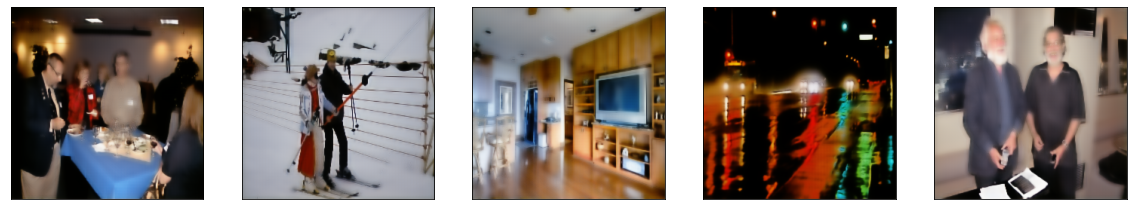

In [19]:
model_dir = pathlib.Path("models_improved//best_model.h5")
model = tf.keras.models.load_model(model_dir)
predictions = model.predict(x_test)
display_image(x_test, 5)
display_image(x_test_noisy, 5)
display_image(predictions, 5)

## 5 Mesure de la performance du modèle <a class="anchor" id="chapter6"></a>

In [20]:
# inputs = Input(shape=(image_w, image_w, 3))

# x = Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
# x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
# x = MaxPooling2D((2, 2), padding="same")(x)
# x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
# x = MaxPooling2D((2, 2), padding="same")(x)
# x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
# x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
# x = MaxPooling2D((2, 2), padding="same")(x)
# x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
# x = MaxPooling2D((2, 2), padding="same")(x)

# # Decoder
# x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(256, (3, 3),  activation="relu", padding="same")(x)
# x = Conv2D(128, (3, 3),  activation="relu", padding="same")(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
# x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# # Autoencoder
# autoencoder = Model(inputs, x)
# model_opt = tf.keras.optimizers.Adam(lr=0.002)
# autoencoder.compile(optimizer=model_opt, loss="binary_crossentropy", metrics=['accuracy'])
# autoencoder.summary()

In [21]:
# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_h, image_h, 3)))
# model.add(MaxPooling2D((2, 2), padding='same'))
# model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D((2, 2), padding='same'))
# model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
 

# model.add(MaxPooling2D((2, 2), padding='same'))
     
# model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
# model.add(UpSampling2D((2, 2)))
# model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
# model.add(UpSampling2D((2, 2)))
# model.add(Conv2D(28, (3, 3), activation='relu', padding='same'))
# model.add(UpSampling2D((2, 2)))
# model.add(Conv2D(3, (3, 3), activation='relu', padding='same'))

In [22]:
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [23]:
# model.fit(x_train_noisy, x_train, epochs=10, batch_size=8, shuffle=True, verbose = 1)

In [24]:
# input_img = Input(shape=(image_w, image_h, 3))
# conv1_1 = Conv2D(32, (3,3), activation="relu", padding="same")(input_img)
# pool1_1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
# conv1_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1_1)
# pool1_2 = MaxPooling2D((2, 2), padding='same')(conv1_2)
# conv1_3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1_2)
# pool1_3 = MaxPooling2D((2, 2), padding='same')(conv1_3)

# conv2_1 = Conv2D(8, (3,3), activation="relu", padding="same")(pool1_3)
# pool2_1 = UpSampling2D()(conv2_1)
# conv2_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2_1)
# pool2_2 = UpSampling2D()(conv2_2)
# conv2_3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2_2)
# pool2_3 = UpSampling2D()(conv2_3)
# conv2_3 = Conv2D(3, (3, 3), activation='relu', padding='same')(pool2_3)

In [25]:
# autoencoder = Model(input_img, conv2_3)
# autoencoder.compile(optimizer=tf.keras.optimizers.Adadelta(), #"Adadelta" ne marche pas,
#                     loss="binary_crossentropy") 
# autoencoder.summary()

In [26]:
# ## Train the model
# history = autoencoder.fit(x_train_noisy, x_train,
#                 epochs=nb_epochs,
#                 batch_size= batch_size,
#                 shuffle= False,
#                 validation_data=(x_test_noisy, x_test)
#                 )

In [27]:
# # Visualisation des pertes d'apprentissage (Train) et de validation (Test)
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()

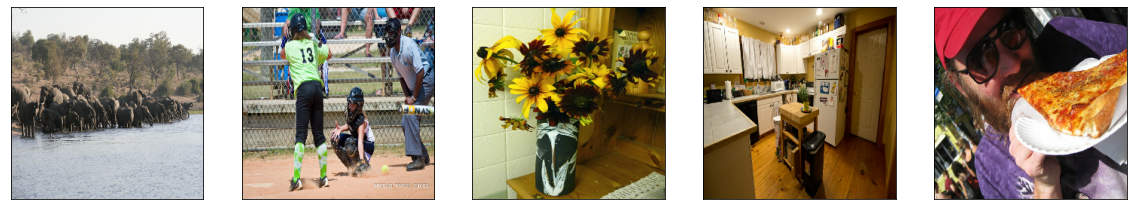

In [28]:
display_image(x_train,5)

In [29]:
# encoder_inputs = Input(shape = (image_h, image_w, 3))

# conv1_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder_inputs)
# pool1 = MaxPooling2D(padding='same')(conv1_1)
# conv1_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
# pool2 = MaxPooling2D(padding='same')(conv1_2)
# conv1_3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
# h = MaxPooling2D(padding='same')(conv1_3)

# conv2_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(h)
# up1 = UpSampling2D()(conv2_1)
# conv2_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
# up2 = UpSampling2D()(conv2_2)
# conv2_3 = Conv2D(16, (3, 3), activation='relu')(up2)
# up3 = UpSampling2D()(conv2_3)
# decoder_outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)

In [30]:
# inputs    = keras.Input(shape=(image_h, image_h, 3))
# x         = Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
# x         = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
# x         = Flatten()(x)
# x         = Dense(16, activation="relu")(x)
# z         = Dense(latent_space_dim)(x)

# encoder = keras.Model(inputs, z, name="encoder")

In [31]:
# inputs  = keras.Input(shape=(latent_space_dim,))
# x       = Dense(7 * 7 * 64, activation="relu")(inputs)
# x       = Reshape((7, 7, 64))(x)
# x       = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
# x       = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# outputs = Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

# decoder = keras.Model(inputs, outputs, name="decoder")

In [32]:
# inputs    = keras.Input(shape=(image_h, image_h, 3))

# latents   = encoder(inputs)
# outputs   = decoder(latents)

# ae = keras.Model(inputs,outputs, name="ae")

# ae.compile(optimizer=keras.optimizers.Adadelta(), loss='binary_crossentropy')

In [33]:
# history = ae.fit(x_train_noisy, x_train,
#                  batch_size      = batch_s,
#                  epochs          = nb_epochs,
#                  validation_data = (x_test_noisy, x_test) )

In [34]:
#autoencoder.compile(optimizer='adadelta', loss='mse')

In [35]:
# history = autoencoder.fit(x_train_noisy, x_train,
#                 epochs=nb_epochs,
#                 batch_size= batch_s,
#                 shuffle= True,
#                 validation_data=(x_test_noisy, x_test)
                         #)

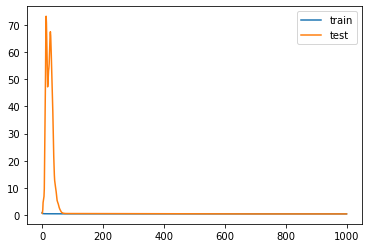

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

## Evaluation des performances de l'autoencodeur

Notre autoencodeur est capable de débruiter toute image bruitée avec un résultat à l'oeil nu convaincant. Evaluons à présent les performances de cet autoencodeur à l'aide de différentes métriques.
Pour l'évaluer et savoir si les images générées par ce dernier sont de qualité, nous allons utiliser des méthodes de comparaison d'images. Nous allons implémenter le <strong>MSE</strong> et le <strong>SSIM</strong>.

- MSE : Mean-square error ou erreur moyenne quadratique est un estimateur d'erreur traditionnel. La MSE mesure,dans notre cas, la différence moyenne au carré entre les images prédites et les images originales. Il suffit donc de calculer les différences entre les images pixel par pixel. Mais cela ne fonctionne bien que si nous voulons générer une image avec les meilleures couleurs de pixel conformes à l'image de base. Dans notre cas, nous voulons nous concentrer sur la structure ou le relief de l'image pour évaluer notre autoencodeur.

Pour pallier ce problème nous avons implémenté également le SSIM.

- SSIM : Structural SIMilarity est une mesure de similarité entre deux images numériques. La SSIM est corrélée à la qualité et à la perception du système visuel humain. Au lieu d'utiliser les méthodes traditionnelles de sommation des erreurs, la SSIM modélise la distorsion de l'image comme une combinaison de trois facteurs qui sont la perte de corrélation, la distorsion de luminance et la distorsion de contraste.

#### Import des images

Nous importons trois images : 
- une image originale
- une image bruitée
- une image générée par l'autoencodeur depuis cette même image bruitée

In [61]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from PIL import Image

size = (226,226)
#On importe et redimensionne notre image de base, la même image bruitée et l'image générée par notre denoiser
img1 = Image.open(r"C:\Users\jbcst\OneDrive\Bureau\img_base.png")
img_resize1 = img1.resize(size)
img = img_as_float(img_resize1)

img2 = Image.open(r"C:\Users\jbcst\OneDrive\Bureau\img_noise.png")
img_resize2 = img2.resize(size)
img_noise = img_as_float(img_resize2)

img3 = Image.open(r"C:\Users\jbcst\OneDrive\Bureau\img_final.png")
img_resize3 = img3.resize(size)
img_const = img_as_float(img_resize3)

#### Implémentation de la MSE et du SSIM

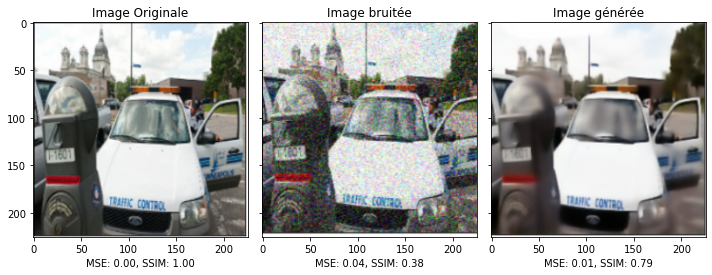

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4),
                         sharex=True, sharey=True)
ax = axes.ravel()

mse_none = mean_squared_error(img, img)
ssim_none = ssim(img, img, data_range=img.max() - img.min(), multichannel=True)

mse_noise = mean_squared_error(img, img_noise)
ssim_noise = ssim(img, img_noise,
                  data_range=img_noise.max() - img_noise.min(), multichannel=True)

mse_const = mean_squared_error(img, img_const)
ssim_const = ssim(img, img_const,
                  data_range=img_const.max() - img_const.min(), multichannel=True)

ax[0].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[0].set_xlabel(f'MSE: {mse_none:.2f}, SSIM: {ssim_none:.2f}')
ax[0].set_title('Image Originale')

ax[1].imshow(img_noise, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[1].set_xlabel(f'MSE: {mse_noise:.2f}, SSIM: {ssim_noise:.2f}')
ax[1].set_title('Image bruitée')

ax[2].imshow(img_const, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[2].set_xlabel(f'MSE: {mse_const:.2f}, SSIM: {ssim_const:.2f}')
ax[2].set_title('Image générée')

plt.tight_layout()
plt.show()

#### Interprétation des résultats

Nous affichons les valeurs de MSE et de SSIM pour chacune de nos images. Le but étant d'avoir la MSE la plus proche de 0 et  une valeur de SSIM la plus proche de 1 possible. Nous voyons donc que notre valeur de MSE pour notre image générée est de 0,01 donc proche de 0, cependant la MSE de l'image bruitée est de 0,04 donc nous ne pouvons pas nous baser sur cette valeur pour évaluer notre modèle.
Voyons voir du coté du SSIM. 
Nous avons une valeur de 0,79 pour l'image générée et une valeur de 0,38 pour l'image bruitée. Nous pouvons en conclure que, pour notre modèle, l'image générée est très similaire à l'image d'origine.

In [37]:
def get_image_test():
    path_test_photo = "D:\exia\A5 2021-2022\Option_DataScience\Dataset"
    test_image = [os.path.join(path_test_photo, x) for x in os.listdir(path_test_photo)][randrange(150)]
    return test_image

def do_test(photo_test, model):
    img = image.load_img(photo_test)
    img = preprocess(img)
    img_noise = noise_it(img)
    img_denoise_encoder = ae.predict(img_noise)
    print(img_denoise_encoder)
    display_image(img, 1)
    display_image(img_noise, 1)
    display_image(img_denoise_encoder, 1)
# test_image = get_image_test()
# do_test(test_image, history)

In [38]:
# input_img = Input(shape = (image_h, image_h,3))
# x = Conv2D(16, (3,3), activation = "relu", padding="same")(input_img)
# x = MaxPooling2D(pool_size=(2,2), padding="same")(x)
# x = Conv2D(32, (3,3), activation = "relu", padding="same")(x)
# encoded = MaxPooling2D()(x)
# x = Conv2D(32, (3,3), activation = "relu", padding="same")(encoded)
# x = UpSampling2D((2))(x)
# x = Conv2D(32, (3,3), activation = "relu", padding="same")(x)
# x = UpSampling2D()(x)
# decoded = Conv2D(3, (3, 3), activation= "sigmoid", padding="same")(x)

In [39]:
# inputs    = tf.keras.Input(shape=(28, 28, 3))

# latents   = encoder(inputs)
# outputs   = decoder(latents)

# ae = tf.keras.Model(inputs,outputs, name="ae")

# ae.compile(optimizer = tf.keras.optimizers.Adadelta(), loss = 'mse')
# ae.summary()

In [40]:
# autoencoder = tf.keras.Model(input_img, decoded)
# autoencoder.compile(optimizer="adadelta",
#                     loss= "binary_crossentropy")
# autoencoder.summary()

In [41]:
# history = ae.fit(x_train_noisy, x_train,
#                 epochs=nb_epochs,
#                 batch_size= batch_size,
#                 shuffle= False,
#                 validation_data=(x_test_noisy, x_test)
#                          )


In [42]:
# def create_dir():
#     bruit_dir = "D:\exia\A5 2021-2022\Option_DataScience\Bruit"
#     if not os.path.exists(bruit_dir):
#         print('test')
#         os.mkdir(bruit_dir)
#         dir_create = map(lambda x : os.path.join(bruit_dir,x), ['Bruit', 'Clean'])
#         [os.mkdir(x) for x in dir_create]
#     return list(map(lambda x: bruit_dir + '\\'+ x ,os.listdir(bruit_dir)))

# def noise_it(list_dir, path_dataset):
#     all_files = [os.path.join(path_dataset, x) for x in os.listdir(path_dataset)]
#     for index, photo in enumerate(all_files):
#         img = image.load_img(photo, target_size=(28, 28))
#         array_img = image.img_to_array(img)
# #         array_img = random_noise(array_img, mode='gaussian', mean=0, var=0.3)
# #         array_img = random_noise(array_img, mode='s&p',      amount=0.2, salt_vs_pepper=0.5)
# #         array_img = random_noise(array_img, mode='poisson') 
# #         array_img = random_noise(array_img, mode='speckle',  mean=0, var=0.1)
# #         array_img = Image.fromarray(array_img.astype('uint8'), 'RGB')
#         img.save(str(list_dir[1]) + "\\"+ photo.split('\\')[-1])
#         array_img.save(str(list_dir[0]) + "\\noisy_"+ photo.split('\\')[-1])
# list_dir = create_dir()
# noise_it(list_dir, r"D:\exia\A5 2021-2022\Option_DataScience\Datasets\Photo")